<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT21/blob/main/template-report-Navier-Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [3]:
# Load neccessary modules.
try:
    from google.colab import files
except:
    pass

import numpy as np
import time

# Install FEniCS
try:
    import dolfin
except ImportError as e:
    !apt-get install -y -qq software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    !sed -i "s|#if PETSC_VERSION_MAJOR == 3 && PETSC_VERSION_MINOR <= 8 && PETSC_VERSION_RELEASE == 1|#if 1|" /usr/include/dolfin/la/PETScLUSolver.h
    !rm -rf /usr/lib/python3/dist-packages/mpi4py*
    !rm -rf /usr/lib/python3/dist-packages/petsc4py*
    !rm -rf /usr/lib/python3/dist-packages/slepc4py*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/dolfin*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/mshr*
    !wget "https://drive.google.com/uc?export=download&id=1cT_QBJCOW_eL3BThnval3bcpb8o0w-Ad" -O /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=119i49bxlGn1mrnhTNmOvM4BqmjrT9Ppr" -O /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-1tVfu8qz3bRC2zvR8n3RESpesWqNnn6" -O /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-3qY4VIJQaXVO1HfGQIzTIURIeJbvX-9" -O /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-5SMjgjMuee_9WLeYtGe8N_lvipWEN7W" -O /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !pip3 install /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 -q install --upgrade sympy
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

In [27]:
fsize = 3

# **Introduction**

The Navier-Stokes equations take the form

$$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term (GLS).

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$$

with $\Phi\in V$ a function for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $$Re=\frac{UD}{\nu}$$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# Method

We make all the computations on a rectangular domain with a circular hole as shown below. The boundary conditions for the top and bottom boundaries are slip boundary conditions ($u \cdot \hat{n} = 0$). On the left it is an inflow boundary condition with $u(x=0,y,t) = (1, 0)$ and $p(x=0,y,t) = \lvert \sin(t) \rvert$. The boundary condition on the right is simply an outflow BC. All of the computations use first-order basis functions with least squares stabilization of the residual. In order to simplify the code later, we wrap all the heavy computations in the function 
`simulate(U, nu, mesh, Tmax, uinit=None, pinit=None, tinit=0.0)`

This function contains everything but the mesh generation, as the mesh is passed as an argument. It is contructed similarly to the template file.


**Definition of the domain and mesh**

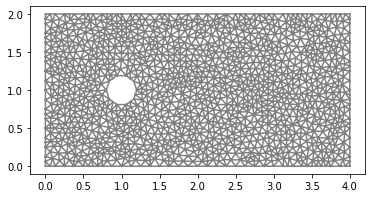

In [189]:
# Define rectangular domain 
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2
D = 2*rc

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()


# Generate mesh (examples with and without a hole in the mesh) 
def genmesh(resolution):
    #mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
    mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

    # Local mesh refinement (specified by a cell marker)
    no_levels = 0
    for i in range(0,no_levels):
      cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
      for cell in cells(mesh):
        cell_marker[cell] = False
        p = cell.midpoint()
        if p.distance(Point(xc, yc)) < 1.0:
            cell_marker[cell] = True
      mesh = refine(mesh, cell_marker)

    # Define mesh functions (for boundary conditions)
    boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
    boundaries.set_all(0)
    left.mark(boundaries, 1)
    right.mark(boundaries, 2)
    lower.mark(boundaries, 3)
    upper.mark(boundaries, 4)
    return mesh

resolution = 32
mesh = genmesh(resolution)

plt.figure()
plot(mesh)
plt.show()

fsize=2

**Define finite element approximation spaces**

In [175]:
def simulate(U, nu, mesh, Tmax, uinit=None, pinit=None, tinit=0.0, SDstab=False):
    # Generate finite element spaces (for velocity and pressure)
    V = VectorFunctionSpace(mesh, "Lagrange", 1)
    Q = FunctionSpace(mesh, "Lagrange", 1)

    # Define trial and test functions 
    u = TrialFunction(V)
    p = TrialFunction(Q)
    v = TestFunction(V)
    q = TestFunction(Q)


    # %% ====================================================================
    # Define boundary conditions 
    class DirichletBoundaryLower(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 0.0)

    class DirichletBoundaryUpper(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], H)

    class DirichletBoundaryLeft(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0.0) 

    class DirichletBoundaryRight(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], L)

    class DirichletBoundaryObjects(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

    dbc_lower = DirichletBoundaryLower()
    dbc_upper = DirichletBoundaryUpper()
    dbc_left = DirichletBoundaryLeft()
    dbc_right = DirichletBoundaryRight()
    dbc_objects = DirichletBoundaryObjects()


    # Examples of time dependent and stationary inflow conditions
    # uin = Expression('6.0*x[1]/H*(1-x[1]/H)', H=H, element = V.sub(0).ufl_element())
    #uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
    uin = U #1.0
    bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
    bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
    bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
    bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
    bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
    bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
    bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
    bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

    pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
    pout = 0.0
    #bcp0 = DirichletBC(Q, pin, dbc_left) 
    bcp1 = DirichletBC(Q, pout, dbc_right)

    #bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
    bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
    bcp = [bcp1]

    # Define measure for boundary integration  
    ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

    # %% ====================================================================
    # Define iteration functions
    # (u0,p0) solution from previous time step
    # (u1,p1) linearized solution at present time step  
    u0 = Function(V)
    u1 = Function(V)
    p0 = Function(Q)
    p1 = Function(Q)

    # Set parameters for nonlinear and lienar solvers 
    num_nnlin_iter = 5 
    prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

    # Time step length 
    dt = 0.5*mesh.hmin()/U


    # %% ====================================================================
    # Define variational problem

    # Stabilization parameters
    h = CellDiameter(mesh)
    u_mag = sqrt(dot(u1,u1))

    # Mean velocities for trapozoidal time stepping
    um = 0.5*(u + u0)
    um1 = 0.5*(u1 + u0)

    if(SDstab):
        d1 = 0.17/sqrt(1/dt**2 + u_mag**2/h**2)
        d2 = 0.17*h

        # Momentum variational equation on residual form
        Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
            + d1*inner(grad(um)*um1, grad(v)*um1)*dx

        # Continuity variational equation on residual form
        Fp = d2*inner(grad(p), grad(q))*dx + div(um1)*q*dx

    else:
        d1 = 1.0/sqrt(1/dt**2 + u_mag**2/h**2)
        d2 = h*u_mag

        # Momentum variational equation on residual form
        Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
            + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx 

        # Continuity variational equation on residual form
        Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx 

    au = lhs(Fu)
    Lu = rhs(Fu)

    ap = lhs(Fp)
    Lp = rhs(Fp)

    # %% ====================================================================
    # Define the direction of the force to be computed in y
    psi_y_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=0.0, phi_y=1.0, element = V.ufl_element())
    psi_y = interpolate(psi_y_expression, V)
    Forcey = inner((u1 - u0)/dt + grad(um1)*um1, psi_y)*dx - p1*div(psi_y)*dx + nu*inner(grad(um1), grad(psi_y))*dx

    # Define the direction of the force to be computed in x
    psi_x_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=1.0, phi_y=0.0, element = V.ufl_element())
    psi_x = interpolate(psi_x_expression, V)
    Forcex = inner((u1 - u0)/dt + grad(um1)*um1, psi_x)*dx - p1*div(psi_x)*dx + nu*inner(grad(um1), grad(psi_x))*dx



    #plt.figure()
    #plot(psi, title="weight function psi")

    # Force normalization
    D = 2*rc
    normalization = -2.0/D

    # %% ====================================================================
    # Open files to export solution to Paraview
    file_u = File("results-NS/u.pvd")
    file_p = File("results-NS/p.pvd")


    # Force computation data 
    force_x_array = np.array(0.0)
    force_x_array = np.delete(force_x_array, 0)
    force_y_array = np.array(0.0)
    force_y_array = np.delete(force_y_array, 0)
    time = np.array(0.0)
    time = np.delete(time, 0)

    print("Computing:")
    print("[%-40s] %2.0f%s" % ("", 0, "%"), end="")

    # %% ====================================================================
    # Time stepping 
    if uinit is not None:
        u0.assign(uinit)
    if pinit is not None:
        p0.assign(uinit)

    T = Tmax + tinit
    t = dt + tinit
    while t < T + DOLFIN_EPS:

        #s = 'Time t = ' + repr(t) 
        #print(s)
        pin.t = t
        #uin.t = t

        # Solve non-linear problem 
        k = 0
        while k < num_nnlin_iter: 
            
            # Assemble momentum matrix and vector 
            Au = assemble(au)
            bu = assemble(Lu)

            # Compute velocity solution 
            [bc.apply(Au, bu) for bc in bcu]
            [bc.apply(u1.vector()) for bc in bcu]
            solve(Au, u1.vector(), bu, "bicgstab", "default")

            # Assemble continuity matrix and vector
            Ap = assemble(ap) 
            bp = assemble(Lp)

            # Compute pressure solution 
            [bc.apply(Ap, bp) for bc in bcp]
            [bc.apply(p1.vector()) for bc in bcp]
            solve(Ap, p1.vector(), bp, "bicgstab", prec)

            k += 1

        # Compute force
        Fx = assemble(Forcex)
        Fy = assemble(Forcey)
        force_x_array = np.append(force_x_array, normalization*Fx)
        force_y_array = np.append(force_y_array, normalization*Fy)
        time = np.append(time, t)

        # Update time step
        print("\r[%-40s] %2.0f%s" % ("="*int(np.ceil(40*t/T)), 100*t/T, "%"), end="")
        u0.assign(u1)
        t += dt
    
    print("\r[%-40s] %2.0f%s" % ("="*40, 100, "%"))

    drag = force_x_array
    lift = force_y_array
    return u1, p1, time, drag, lift, dt

# Results

We first simulate the flow with various values of $\nu$ and look at the drag and lift coefficients. 

In [107]:
nus = np.array([4e-1, 4e-2, 4e-3, 4e-4])
U = 1.0

results = []
for nu in nus:
    results += [simulate(U=U, nu=nu, mesh=mesh, Tmax=20.0, uinit=None, pinit=None, tinit=0.0)]
    

Computing:
[========================================] 100%
Computing:
[========================================] 100%
Computing:
[========================================] 100%
Computing:
[========================================] 100%


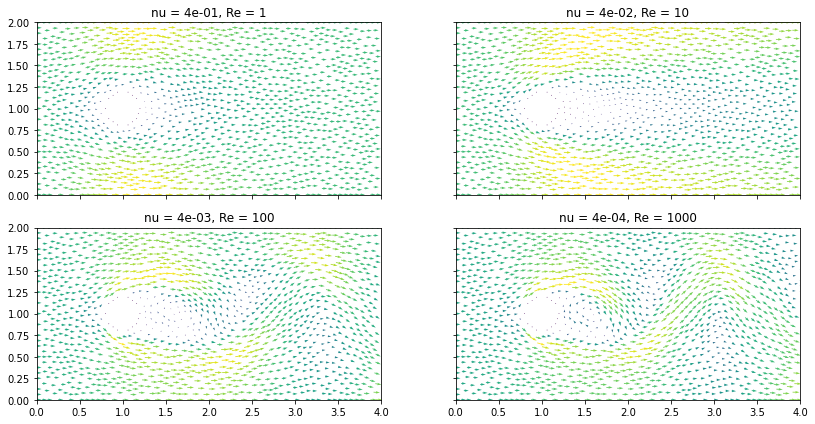

In [108]:
results = np.array(results, dtype=object)
Usol = results[:,0]
Psol = results[:,1]
time = results[0,2]
drag = results[:,3]
lift = results[:,4]
dt = results[0,5]

Re = U*D/nus
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(fsize*L, fsize*H))
axes = axes.ravel()
for (i, nu) in enumerate(nus):
    plt.sca(axes[i])
    plt.title("nu = %.0e, Re = %.0f" % (nu, Re[i]))
    plot(results[i,0])
    plt.xlim((0,L))
    plt.ylim((0,H))
plt.tight_layout()
plt.show()


As we expect it, low Reynolds (10, 100) numbers result in a steady flow. Higher Reynolds numbers produce 
Kármán vortex streets with increasing. For these cases we can compute the Strouhal number below: We indeed verify that the vortex streets have a Strouhal number of $\approx 0.2$


In [169]:
freq = np.empty(4)
val = time>2
for (i, nu) in enumerate(nus):
    sig = np.sign(lift[i][val])
    sc_pos = np.nonzero(sig[1:] != sig[:-1])[0][1:-1]
    
    try:
        nperiod = np.mean(sc_pos[2:] - sc_pos[1:-1])*2 #find mean number of iters for a sign change
        nperiod = np.nan if nperiod <= 4 else nperiod #if oscillates too fast => means it's not physical
    except:
        nperiod = np.nan
    period = dt*nperiod
    freq[i] = 1/period
St = freq*D/U
print("Re: %5.0f  %5.0f  %5.0f  %5.0f" % tuple(Re))
print("St: %5.3f  %5.3f  %5.3f  %5.3f" % tuple(St))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

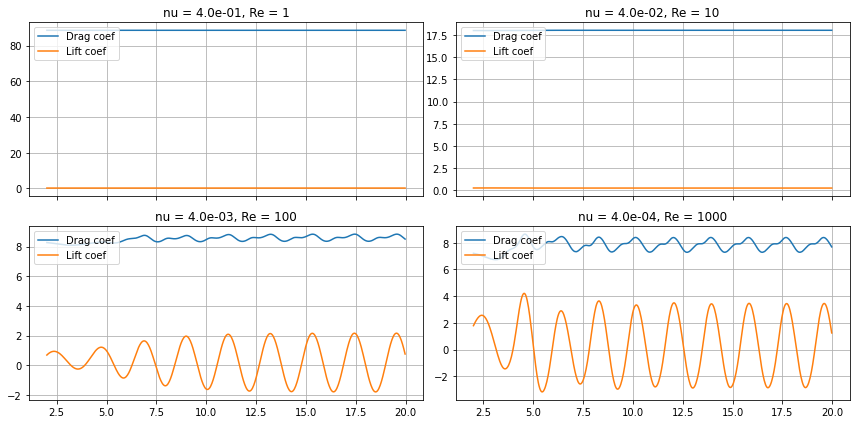

Re:       1     10    100   1000
Drag: 88.58  18.03   8.50   7.79
Lift: 0.189  0.264  0.281  0.388


In [111]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(2*fsize*L, 2*fsize*H))
axes = axes.ravel()
val = time>2
drags = np.empty(4)
lifts = np.empty(4)

for (i, nu) in enumerate(nus):
    plt.sca(axes[i])
    plt.title("nu = %.1e, Re = %.0f" % (nu, Re[i]))
    plt.plot(time[val], 2*drag[i][val]/(U**2*D), label='Drag coef')
    plt.plot(time[val], 2*lift[i][val]/(U**2*D), label='Lift coef')
    plt.legend(loc = "upper left")
    plt.grid()
    drags[i] = np.mean(drag[i][val])
    lifts[i] = np.mean(lift[i][val])

    
plt.tight_layout()
plt.show()

print("Re:   %5.0f  %5.0f  %5.0f  %5.0f" % tuple(Re))
print("Drag: %5.2f  %5.2f  %5.2f  %5.2f" % tuple(2*drags/(U**2*D)))
print("Lift: %5.3f  %5.3f  %5.3f  %5.3f" % tuple(2*lifts/(U**2*D)))

Computing the drag and lift coefficients reveals that the drag is high with a high viscosity/ low Reynolds. Note that the force normalization of $2/D$ is important for the numerical value. The lift coefficient should theoretically be $0$, as the domain, the initial conditions and the boundary conditions are symetrical around $y=H/2$. Here we see a slightly positive lift coefficient, but this is only due discretization and to the average value of the coefficient not being computed over a whole number of periods. Using the same parameters, but with a mesh resolution of 25, gives a negative lift coefficient. Increasing the resolution reduces the lift coefficient.

### mesh refinement
We now inspect different meshes with $Re=100$.

In [125]:
refs = [8*2**i for i in range(4)]
meshes = [genmesh(r) for r in refs]
nu = 4e-3

results = []
for (i, mesh) in enumerate(meshes):
    results += [simulate(U=U, nu=nu, mesh=mesh, Tmax=20.0, uinit=None, pinit=None, tinit=0.0)]


Computing:
[========================================] 100%
Computing:
[========================================] 100%
Computing:
[========================================] 100%
Computing:
[                                        ]  0%Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
[========================================] 100%


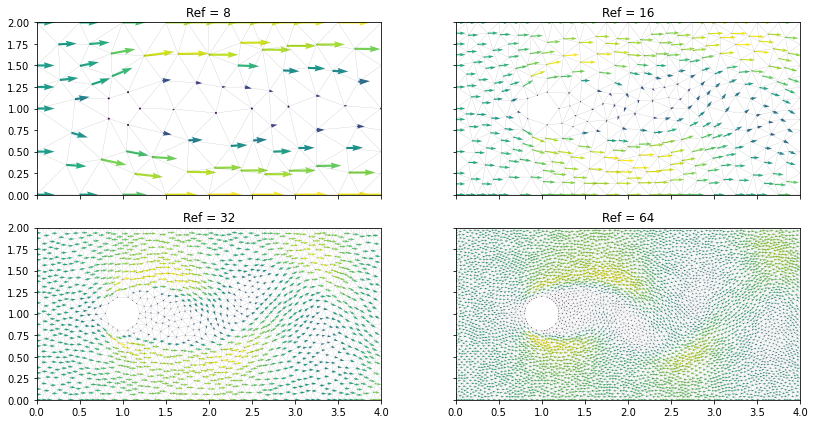

In [174]:
results = np.array(results, dtype=object)
Usol = results[:,0]
Psol = results[:,1]
time = results[:,2]
drag = results[:,3]
lift = results[:,4]
dts = results[:,5]

Re = U*D/nu
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(2*fsize*L, 2*fsize*H))
axes = axes.ravel()
for (i, ref) in enumerate(refs):
    plt.sca(axes[i])
    plt.title("Ref = %d" % ref)
    plot(meshes[i], linewidth=0.1, color="k", alpha=0.7)
    plot(results[i,0])
    plt.xlim((0,L))
    plt.ylim((0,H))
plt.tight_layout()
plt.show()


In [172]:
freq = np.empty(4)
for (i, ref) in enumerate(refs):
    val = time[i]>5
    sig = np.sign(lift[i][val])
    sc_pos = np.nonzero(sig[1:] != sig[:-1])[0][1:-1]
    #print(sc_pos[2:] - sc_pos[1:-1])
    try:
        nperiod = np.mean(sc_pos[2:] - sc_pos[1:-1])*2 #find mean number of iters for a sign change
        nperiod = np.nan if nperiod <= 4 else nperiod #if oscillates too fast => means it's not physical
    except:
        nperiod = np.nan
    period = dts[i]*nperiod
    freq[i] = 1/period
St = freq*D/U
print("Ref: %5d  %5d  %5d  %5d" % tuple(refs))
print("St:  %5.3f  %5.3f  %5.3f  %5.3f" % tuple(St))

Ref:     8     16     32     64
St:    nan  0.164  0.190  0.204


The flow for the different meshes is shown above. Computing the Strouhal number shows that a finer mesh resolution increases the strouhal number. If the mesh is too coarse, then it is unable to resolve the vortexes and there is no oscillation. The plot of the drag and lift coefficients are shown below.

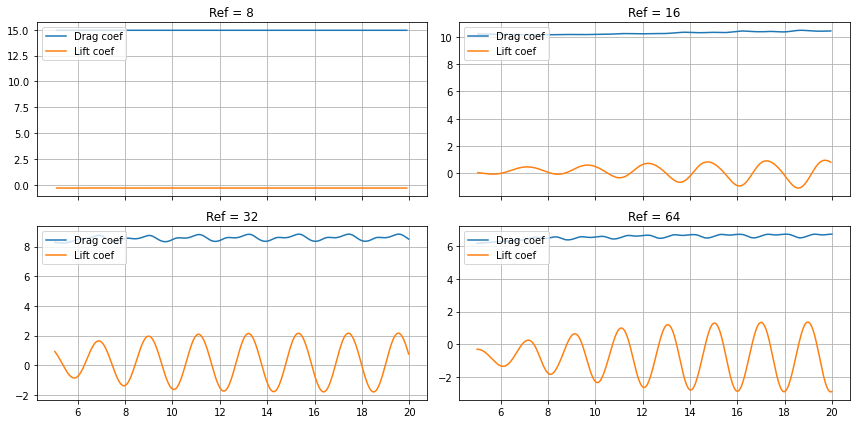

Ref:      8     16     32     64
Drag: 14.95  10.27   8.57   6.58
Lift: -0.29   0.13   0.23  -0.74


In [167]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(fsize*L, fsize*H))
axes = axes.ravel()
drags = np.empty(4)
lifts = np.empty(4)

for (i, ref) in enumerate(refs):
    val = time[i]>5
    plt.sca(axes[i])
    plt.title("Ref = %d" % ref)
    plt.plot(time[i][val], 2*drag[i][val]/(U**2*D), label='Drag coef')
    plt.plot(time[i][val], 2*lift[i][val]/(U**2*D), label='Lift coef')
    plt.legend(loc = "upper left")
    plt.grid()
    drags[i] = np.mean(drag[i][val])
    lifts[i] = np.mean(lift[i][val])

    
plt.tight_layout()
plt.show()

print("Ref:  %5d  %5d  %5d  %5d" % tuple(refs))
print("Drag: %5.2f  %5.2f  %5.2f  %5.2f" % tuple(2*drags/(U**2*D)))
print("Lift: %5.2f  %5.2f  %5.2f  %5.2f" % tuple(2*lifts/(U**2*D)))

Contrary to the Strouhal number, the drag coefficient is overestimated in coarse meshes an decreases as the mesh is refined. The lift coefficient is still close to 0, as it should be, randomly alternating between positive and negative values.

## Streamline diffusion stabilization
We now compare the GLS method with the Streamline diffusion stabilization method, as described in section 5.5 of the lecture notes. As can be seen below, SD stabilization is much more diffusive, at least in the present implementation. (The high sensitivity of the results to the value of the coefficient $\delta_1$ may suggest that there is a mistake in the implementation)

In [194]:
refs = [8*2**i for i in range(3)]
meshes = [genmesh(r) for r in refs]
methods = [False, True]
nu = 4e-3

results = []
for (i, mesh) in enumerate(meshes):
    for method in methods:
        results += [simulate(U=U, nu=nu, mesh=mesh, Tmax=10.0, uinit=None, pinit=None, tinit=0.0, SDstab=method)]


Computing:
[========================================] 100%
Computing:
[========================================] 100%
Computing:
[========================================] 100%
Computing:
[========================================] 100%
Computing:
[========================================] 100%
Computing:
[========================================] 100%


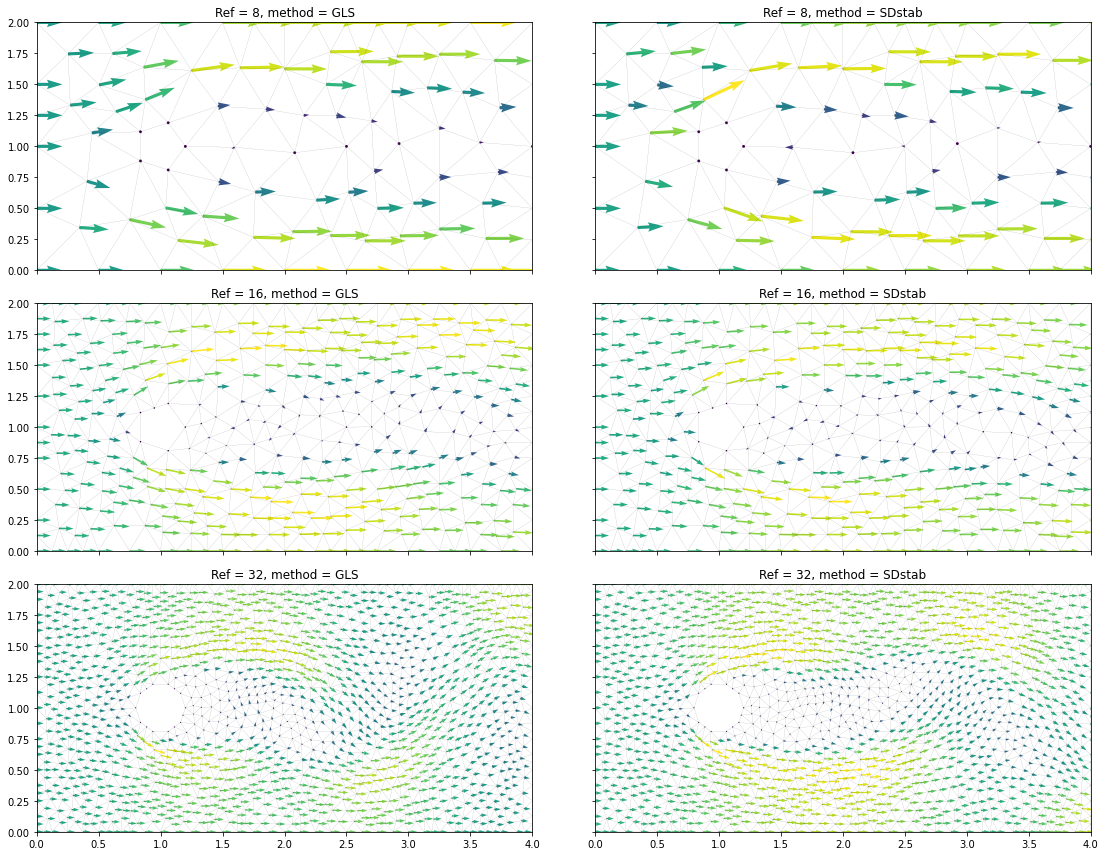

In [195]:
meshes2 = np.repeat(meshes, 2)
refs2 = np.repeat(refs, 2)
methods2 = np.tile(methods, 3)


results = np.array(results, dtype=object)
Usol = results[:,0]
Psol = results[:,1]
time = results[:,2]
drag = results[:,3]
lift = results[:,4]
dts = results[:,5]

Re = U*D/nu
fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(2*fsize*L, 3*fsize*H))
axes = axes.ravel()
for (i, ref) in enumerate(refs2):
    plt.sca(axes[i])
    plt.title("Ref = %d, method = %s" % (ref, "GLS"*(1-methods2[i]) + "SDstab"*int(methods2[i])))
    plot(meshes2[i], linewidth=0.1, color="k", alpha=0.7)
    plot(results[i,0])
    plt.xlim((0,L))
    plt.ylim((0,H))
plt.tight_layout()
plt.show()



Compared to the GLS method, the streamline diffusion stabilization looks significantly less swirly. The flow is stable but looks too straight. 

**Compute force on boundary**

**Set plotting variables and open export files**

**Time stepping algorithm**

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street)